# Convolutional Neural Networks
   


### Vamos a construir una red neuronal que reconoce imágenes de los 10 deportes más populares del mundo de tamaño 21x28 píxeles (pequeñas pero suficiente para que pueda reconocerlo) en color, con un total de 77.000 fotos con el objetivo de que nuestra red neuronal pueda reconocer y clasificar dada una nueva imagen de qué deporte se trata



#### En primer lugar, importamos las librerías `numpy` y `keras`

In [16]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras
from keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

#### A continuación, cargamos las imágenes con `plt.imread(filepath)` 

In [2]:
dirname = os.path.join(os.getcwd(), 'sportimages')
imgpath = dirname + os.sep 
 
images = []
directories = []
dircount = []
prevRoot=''
cant=0
 
print("leyendo imagenes de ",imgpath)
 
for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)
 
dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  /Users/pedro/sportimages/
/Users/pedro/sportimages/golf 1
/Users/pedro/sportimages/basket 9768
/Users/pedro/sportimages/tenis 8823
/Users/pedro/sportimages/natacion 8937
/Users/pedro/sportimages/ciclismo 5172
/Users/pedro/sportimages/beisball 7533
/Users/pedro/sportimages/futbol 7752
/Users/pedro/sportimages/americano 7617
/Users/pedro/sportimages/f1 9348
/Users/pedro/sportimages/boxeo 5053
Directorios leidos: 10
Imagenes en cada directorio [9769, 8823, 8937, 5172, 7533, 7752, 7617, 9348, 5053, 7124]
suma Total de imagenes en subdirs: 77128


#### Después, creamos las etiquetas con  `labels`, proporcionándole un valor del 0 al 9 a cada deporte. Luego convertimos las etiquetas y las imágenes en numpy array con `np.array()`


In [3]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))
 
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1
 
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
 
# Encontrar el número de la etiqueta de entrenamiento
classes = np.unique(y)
nClasses = len(classes)
print('Número total de outputs : ', nClasses)
print('Output clases : ', classes)

Cantidad etiquetas creadas:  77128
0 golf
1 basket
2 tenis
3 natacion
4 ciclismo
5 beisball
6 futbol
7 americano
8 f1
9 boxeo
Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


#### Creamos dos sets diferentes: el set de entrenamiento y el set de testing. Preprocesamos el valor de los pixeles y lo normalizamos para que tengan un valor entre 0 y 1, por eso dividimos en 255. Ademas haremos el «One-Hot encoding» con `to_categorical()`  que converiete las etiquetas por ejemplo de fútbol un 6 a una salida de tipo (0 0 0 0 0 0 1 0 0 0) para que así funcione mejor nuestra red neuronal y se corresponde con una capa de salida de la red neuronal de 10 neuronas.

#### Por último, en este bloque, subdividimos los datos en 80-20 para test y entrenamiento con `train_test_split()` y nuevamente en 80-20 el de training para obtener un subconjunto de validación.

In [17]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Datos del training : ', train_X.shape, train_Y.shape)
print('Datos del test : ', test_X.shape, test_Y.shape)
 
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.
 
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)
 
# Display the change for category label using one-hot encoding
print('Etiqueta original:', train_Y[0])
print('Después de la conversión One-Hot:', train_Y_one_hot[0])
 
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)
 
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

Datos del training :  (61702, 21, 28, 3) (61702,)
Datos del test :  (15426, 21, 28, 3) (15426,)
Etiqueta original: 7
Después de la conversión One-Hot: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(49361, 21, 28, 3) (12341, 21, 28, 3) (49361, 10) (12341, 10)


#### Ahora sí que nos apoyamos en Keras para crear la Convolutional Neural Network. 

+ Declaramos 3 constantes:
        + El valor inicial del learning rate `INIT_L`
        + Cantidad de `epochs`
        + Tamaño batch de imágenes a procesar `batch_size` (cargan en memoria).
+ Crearemos una primer capa de neuronas Convolucional de 2 Dimensiones `Conv2D()`, donde entrarán nuestras imágenes de 21x28x3. Donde 3 hace referencia a los canales de colores que tiene la imagen (RGB) que tiene valores de 0 a 255
+ Aplicaremos 32 filtros de tamaño 3×3 que detectan ciertas características de la imagen (ejemplo: lineas verticales).
+ Utilizaremos La función `LeakyReLU` como activación de las neuronas.
+ Haremos un MaxPooling (de 2×2) que reduce la imagen que entra de 21×28 a la mitad,(11×14) manteniendo las características «únicas» que detectó cada kernel.
+ Para evitar el overfitting, añadimos una técnica llamada Dropout
+ «Aplanamos» `Flatten()`  los 32 filtros y creamos una capa de 32 neuronas «tradicionales» Dense()
+ Y finalizamos la capa de salida con 10 neuronas con activación Softmax, para que se corresponda con el «hot encoding» que hicimos antes.
+ Luego compilamos nuestra red `sport_model.compile()`  y le asignamos un optimizador (en este caso de llama Adagrad).

In [5]:
INIT_LR = 1e-3
epochs = 6
batch_size = 64
 
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))
 
sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5)) 
sport_model.add(Dense(nClasses, activation='softmax'))
 
sport_model.summary()
 
sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 21, 28, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 21, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4928)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                157728    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32)              

#### Iniciaremos el entrenamiento y validación de nuestra red neuronal con esta linea `sport_model.fit()`  y la red se irá regulando sola, «aprendiendo» los mejores pesos para las más de 150.000 interconexiones para distinguir los 10 deportes

#### Por último guardamos la red YA ENTRENADA `sport_model.save()` en un formato de archivo h5py ya que nos permitirá poder utilizarla en el futuro SIN necesidad de volver a entrenar 

In [6]:
sport_train_dropout = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))
 
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("sports_mnist.h5py")


Train on 49361 samples, validate on 12341 samples
Epoch 1/6
49361/49361 [==============================] - 52s 1ms/step - loss: 1.4740 - accuracy: 0.5194 - val_loss: 1.0153 - val_accuracy: 0.7499
Epoch 2/6
49361/49361 [==============================] - 46s 928us/step - loss: 1.1703 - accuracy: 0.6213 - val_loss: 0.8723 - val_accuracy: 0.7871
Epoch 3/6
49361/49361 [==============================] - 45s 921us/step - loss: 1.0724 - accuracy: 0.6571 - val_loss: 0.7867 - val_accuracy: 0.8097
Epoch 4/6
49361/49361 [==============================] - 45s 920us/step - loss: 1.0005 - accuracy: 0.6830 - val_loss: 0.7324 - val_accuracy: 0.8204
Epoch 5/6
49361/49361 [==============================] - 46s 942us/step - loss: 0.9547 - accuracy: 0.6995 - val_loss: 0.6886 - val_accuracy: 0.8395
Epoch 6/6
49361/49361 [==============================] - 45s 904us/step - loss: 0.9116 - accuracy: 0.7122 - val_loss: 0.6480 - val_accuracy: 0.8543


#### En las siguientes líneas de código probamos nuestra red neuronal con imágenes que no ha visto antes (el 20% reservado para el test) donde vemos que alcanza una precisión del 84%


In [7]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)
 
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

15426/15426 [==============================] - 4s 250us/step
Test loss: 0.6611896084826094
Test accuracy: 0.8472708463668823


In [9]:
predicted_classes2 = sport_model.predict(test_X)

In [10]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [11]:
predicted_classes.shape, test_Y.shape

((15426,), (15426,))

Found 13070 correct labels


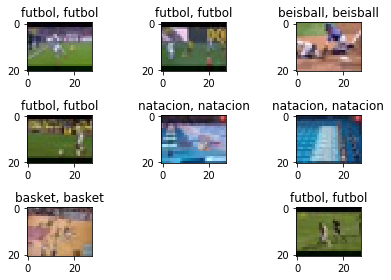

In [13]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 2356 incorrect labels


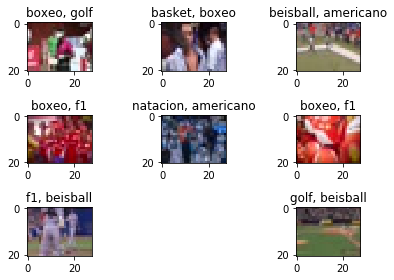

In [14]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [15]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.68      0.92      0.79      1965
     Class 1       0.88      0.90      0.89      1770
     Class 2       0.97      1.00      0.99      1798
     Class 3       0.92      0.93      0.93      1022
     Class 4       0.95      0.99      0.97      1502
     Class 5       0.87      0.78      0.82      1567
     Class 6       0.94      0.83      0.88      1523
     Class 7       0.72      0.66      0.69      1854
     Class 8       0.84      0.43      0.57      1054
     Class 9       0.83      0.94      0.88      1371

    accuracy                           0.85     15426
   macro avg       0.86      0.84      0.84     15426
weighted avg       0.85      0.85      0.84     15426

